In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import time

import matplotlib.pyplot as plt

import scipy
from scipy import linalg

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from WrapScalableSVM import *
from Utils_SSVM import *
from utilsData import *
from modelEvaluation import *
from utilsPlot import *

import joblib

# Tests for the xAI-2024 conference paper
# Load datasets

In [2]:
datapath = "simulationVictor/"
train = "train.csv"
test = "test.csv"
cal = "calib.csv"

In [3]:
dbtrain = pd.read_csv(datapath+train)
dbtest = pd.read_csv(datapath+test)
dbcal = pd.read_csv(datapath+cal)
dbtrain

,SafetyMargin,Eta,Tau,output
0,0.056157,0.374912,0.912839,17
1,0.033138,0.165715,0.824695,97
2,0.055506,0.932224,0.866350,12
3,0.030694,0.709492,0.017845,0
4,0.095292,0.434869,0.102331,0
...,...,...,...,...
3995,0.034414,0.279374,0.001819,0
3996,0.057528,0.323413,0.425907,0
3997,0.051730,0.317743,0.526581,0
3998,0.087183,0.533024,0.220642,0


Separate features and labels, and convert label 0 with 1 and 1 with -1

In [4]:
Xtr = dbtrain[['SafetyMargin', 'Eta', 'Tau']].values
Ytr = dbtrain[['output']].values
Ytr[Ytr>1] = -1
Ytr[Ytr==0] = 1

Xts = dbtest[['SafetyMargin', 'Eta', 'Tau']].values
Yts = dbtest[['output']].values
Yts[Yts>1] = -1
Yts[Yts==0] = 1

Xcal = dbcal[['SafetyMargin', 'Eta', 'Tau']].values
Ycal = dbcal[['output']].values
Ycal[Ycal>1] = -1
Ycal[Ycal==0] = 1

In [14]:
print(dbtrain.info())
print(Xtr.dtype)
Ytr.dtype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SafetyMargin  4000 non-null   float64
 1   Eta           4000 non-null   float64
 2   Tau           4000 non-null   float64
 3   output        4000 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 125.1 KB
None
float64


dtype('int64')

# SVM parameters setting

In [15]:
# Parameters settings
kernel = "polynomial"
param = 3
tau = np.array([[0.5]])
eta = 0.3

# Scaling setting

In [16]:
epsilon = 0.1

## 1) Classic SVM

In [17]:
start_time = time.time()

model = ScalableSVMClassifier(eta, kernel, param, tau)

model = model.fit(Xtr,Ytr)
joblib.dump(model, datapath+"classicSVM_safeEff.sav")
end_time = time.time()

elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 45.85892295837402 seconds


In [11]:
model = model.FPcontrol(Xcal, Ycal, epsilon,'classic')
model.get_params()

{'alpha': array([-3.60960298e-05, -5.94496368e-06,  4.99781884e-01, ...,
         4.99959117e-01, -3.87267241e-05,  5.00202682e-01]),
 'b': array([-0.12019627]),
 'b_eps': 0,
 'eta': 0.3,
 'kernel': 'polynomial',
 'param': 3,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

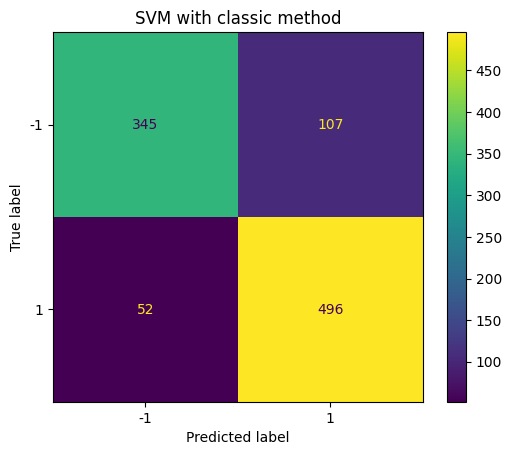

ACC = 0.841, F1 = 0.8618592528236316, PPV = 0.8225538971807629, NPV = 0.8690176322418136, TPR = 0.9051094890510949, TNR = 0.7632743362831859, FPR = 0.23672566371681417, FNR = 0.0948905109489051

TP = 496, FP = 107, TN = 345, FN = 52


In [12]:
metricsClassic = EvaluateModel(model, Xts, Yts, f"SVM with {model.method} method")


In [13]:
joblib.dump(model,datapath+"Classic_SVM_safe.sav")

['simulationVictor/Classic_SVM_safe.sav']

## 2) Probabilistic Safety Region

In [14]:
model = model.FPcontrol(Xcal, Ycal, epsilon,'ps')
model.get_params()

0.2418774891053671

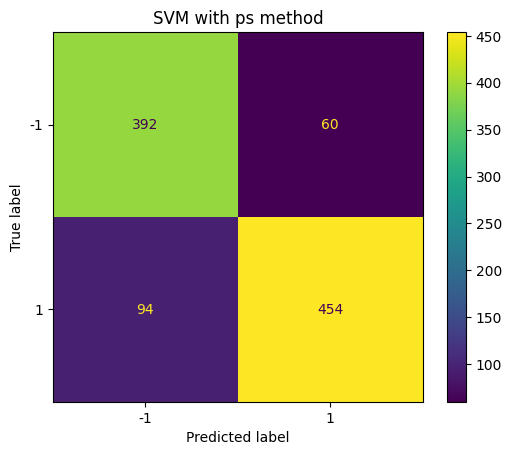

ACC = 0.846, F1 = 0.8549905838041432, PPV = 0.8832684824902723, NPV = 0.8065843621399177, TPR = 0.8284671532846716, TNR = 0.8672566371681416, FPR = 0.13274336283185842, FNR = 0.17153284671532848

TP = 454, FP = 60, TN = 392, FN = 94


In [16]:
metricsPSR = EvaluateModel(model, Xts, Yts, f"SVM with {model.method} method")

In [17]:
joblib.dump(model,datapath+"PS_SVM_safe.sav")

['simulationVictor/PS_SVM_safe.sav']

In [18]:
# save to file
y_ps_tr = model.predict(Xtr).reshape((len(Xtr),1))
y_ps_cal = model.predict(Xcal).reshape((len(Xcal),1))
y_ps_ts = model.predict(Xts).reshape((len(Xts),1))

train = pd.DataFrame(np.hstack((Xtr,Ytr,y_ps_tr)), columns = ["SafetyMargin","Eta","Tau","y_true","y_conformal"])
calib = pd.DataFrame(np.hstack((Xcal,Ycal,y_ps_cal)), columns = ["SafetyMargin","Eta","Tau","y_true","y_conformal"])
test = pd.DataFrame(np.hstack((Xts,Yts,y_ps_ts)), columns = ["SafetyMargin","Eta","Tau","y_true","y_conformal"])
train.to_csv(datapath+"train_ps.csv", index = False)
calib.to_csv(datapath+"calib_ps.csv", index = False)
test.to_csv(datapath+"test_ps.csv", index = False)

# 3) Conformal Safety Regions


In [22]:
model = model.FPcontrol(Xcal, Ycal, 0.1,'cp')
model.get_params()

{'alpha': array([-3.60960298e-05, -5.94496368e-06,  4.99781884e-01, ...,
         4.99959117e-01, -3.87267241e-05,  5.00202682e-01]),
 'b': array([-0.12019627]),
 'b_eps': 0.16828101780637864,
 'eta': 0.3,
 'kernel': 'polynomial',
 'param': 3,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

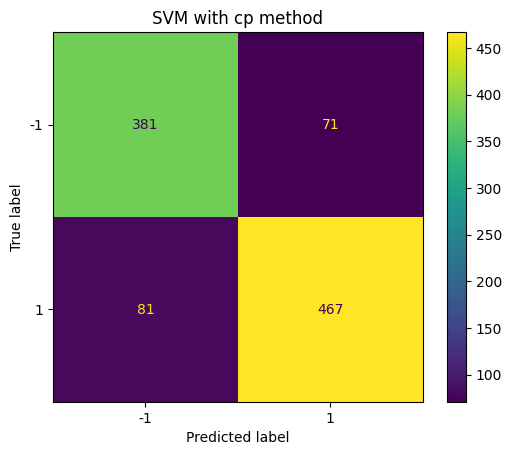

ACC = 0.848, F1 = 0.860036832412523, PPV = 0.8680297397769516, NPV = 0.8246753246753247, TPR = 0.8521897810218978, TNR = 0.8429203539823009, FPR = 0.1570796460176991, FNR = 0.1478102189781022

TP = 467, FP = 71, TN = 381, FN = 81


In [23]:
metricsCSR = EvaluateModel(model, Xts, Yts, f"SVM with {model.method} method")

In [24]:
joblib.dump(model,datapath+"CP_SVM_safe.sav")

['simulationVictor/CP_SVM_safe.sav']

In [25]:
# save to file
y_ps_tr = model.predict(Xtr).reshape((len(Xtr),1))
y_ps_cal = model.predict(Xcal).reshape((len(Xcal),1))
y_ps_ts = model.predict(Xts).reshape((len(Xts),1))

train = pd.DataFrame(np.hstack((Xtr,Ytr,y_ps_tr)), columns = ["SafetyMargin","Eta","Tau","y_true","y_conformal"])
calib = pd.DataFrame(np.hstack((Xcal,Ycal,y_ps_cal)), columns = ["SafetyMargin","Eta","Tau","y_true","y_conformal"])
test = pd.DataFrame(np.hstack((Xts,Yts,y_ps_ts)), columns = ["SafetyMargin","Eta","Tau","y_true","y_conformal"])
train.to_csv(datapath+"train_cp.csv", index = False)
calib.to_csv(datapath+"calib_cp.csv", index = False)
test.to_csv(datapath+"test_cp.csv", index = False)